# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [1]:
# Import Python packages 
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [2]:
# checking your current working directory
print(os.getcwd())

# Get your current folder and subfolder event data
filepath = os.getcwd() + '/event_data'

# Create a for loop to create a list of files and collect each filepath
for root, dirs, files in os.walk(filepath):
    
# join the file path and roots with the subdirectories using glob
    file_path_list = glob.glob(os.path.join(root,'*'))
    #print(file_path_list)

/Users/tracynguyen/Desktop/udacity/TN-project2-DataModeling-Cassandra


#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [3]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 
            
# uncomment the code below if you would like to get total number of rows 
#print(len(full_data_rows_list))
# uncomment the code below if you would like to check to see what the list of event data rows will look like
#print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))


In [4]:
# check the number of rows in your csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

6821


# Part II. Complete the Apache Cassandra coding portion of your project. 

## Now you are ready to work with the CSV file titled <font color=red>event_datafile_new.csv</font>, located within the Workspace directory.  The event_datafile_new.csv contains the following columns: 
- artist 
- firstName of user
- gender of user
- item number in session
- last name of user
- length of the song
- level (paid or free song)
- location of the user
- sessionId
- song title
- userId

The image below is a screenshot of what the denormalized data should appear like in the <font color=red>**event_datafile_new.csv**</font> after the code above is run:<br>

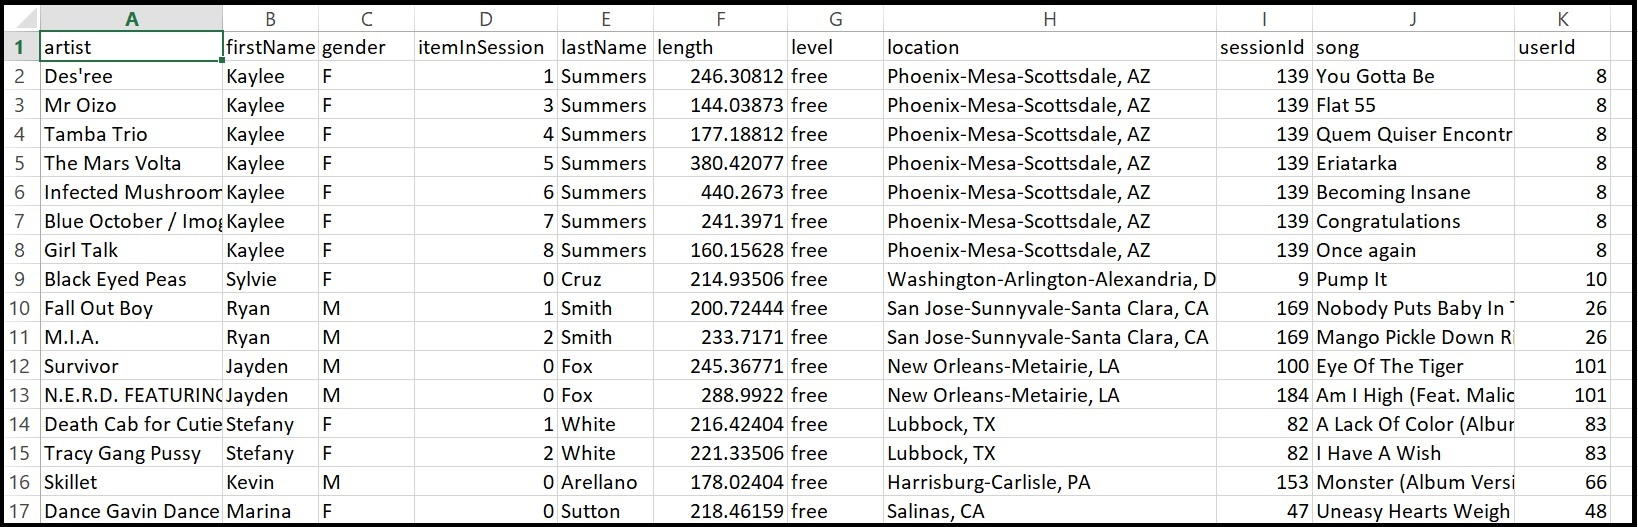

## Begin writing your Apache Cassandra code in the cells below

#### Creating a Cluster

In [5]:
# This should make a connection to a Cassandra instance your local machine 
# (127.0.0.1)

from cassandra.cluster import Cluster
cluster = Cluster()

# To establish connection and begin executing queries, need a session
session = cluster.connect()

#### Create Keyspace

In [6]:
# TO-DO: Create a Keyspace 

try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }"""
)

except Exception as e:
    print(e)

#### Set Keyspace

In [7]:
# TO-DO: Set KEYSPACE to the keyspace specified above
try:
    session.set_keyspace('udacity')
except Exception as e:
    print(e)

### Now we need to create tables to run the following queries. Remember, with Apache Cassandra you model the database tables on the queries you want to run.

## Create queries to ask the following three questions of the data

### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4


### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
    

### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'




In [8]:
## TO-DO: Query 1:  Give me the artist, song title and song's length in the music app history that was heard during \
## sessionId = 338, and itemInSession = 4
query = "CREATE TABLE IF NOT EXISTS song_info_by_session"
query = query + "(sessionid int, iteminsession int, artist text, song text, length float, PRIMARY KEY (sessionid, iteminsession, artist))"

try:
    session.execute(query)
except Exception as e:
    print(e)                    

In [9]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
## TO-DO: Assign the INSERT statements into the `query` variable
        query = "INSERT INTO song_info_by_session(sessionid, iteminsession, artist,song,length)"
        query = query + "VALUES(%s,%s,%s,%s,%s)"
        ## TO-DO: Assign which column element should be assigned for each column in the INSERT statement.
        ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9],float(line[5])))

#### Do a SELECT to verify that the data have been inserted into each table

In [18]:
## TO-DO: Add in the SELECT statement to verify the data was entered into the table
query = "SELECT artist, song, length FROM song_info_by_session WHERE sessionid = 338 AND iteminsession = 4"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print ("Artist:",row.artist,"Song Title:", row.song, "Song Length:",row.length)

Artist: Faithless Song Title: Music Matters (Mark Knight Dub) Song Length: 495.30731201171875


### COPY AND REPEAT THE ABOVE THREE CELLS FOR EACH OF THE THREE QUESTIONS

In [24]:
## TO-DO: Query 2: Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name)\
## for userid = 10, sessionid = 182

query = "CREATE TABLE IF NOT EXISTS song_info_by_user"
query = query + "(sessionid int, iteminsession int, \
userid int, firstname text, lastname text, artist text, song text, length float, \
PRIMARY KEY (userid, sessionid, iteminsession))"

try:
    session.execute(query)
except Exception as e:
    print(e)
                    

In [23]:
query = "DROP TABLE IF EXISTS song_info_by_user"

try:
    session.execute(query)
except Exception as e:
    print(e)

In [25]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
## TO-DO: Assign the INSERT statements into the `query` variable
        query = "INSERT INTO song_info_by_user(sessionid, iteminsession, userid, firstname, lastname,\
    artist,song,length)"
        query = query + "VALUES(%s,%s,%s,%s,%s,%s,%s,%s)"
        ## TO-DO: Assign which column element should be assigned for each column in the INSERT statement.
        ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
        session.execute(query, (int(line[8]), int(line[3]), int(line[10]), line[1], line[4] ,line[0], line[9],float(line[5])))

In [31]:
## TO-DO: Add in the SELECT statement to verify the data was entered into the table
query = "SELECT artist, song,  firstname, lastname FROM song_info_by_user WHERE userid = 10 AND sessionid = 182"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print ("Artist:", row.artist, ",","Song_Title:", row.song, ",","User_First Name:" ,row.firstname,",", "User_Last_Name:", row.lastname)

Artist: Down To The Bone , Song_Title: Keep On Keepin' On , User_First Name: Sylvie , User_Last_Name: Cruz
Artist: Three Drives , Song_Title: Greece 2000 , User_First Name: Sylvie , User_Last_Name: Cruz
Artist: Sebastien Tellier , Song_Title: Kilometer , User_First Name: Sylvie , User_Last_Name: Cruz
Artist: Lonnie Gordon , Song_Title: Catch You Baby (Steve Pitron & Max Sanna Radio Edit) , User_First Name: Sylvie , User_Last_Name: Cruz


In [48]:
## TO-DO: Query 3: Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'

query = "CREATE TABLE IF NOT EXISTS user_info"
query = query + "(userid int, firstname text, lastname text, song text, PRIMARY KEY (song, userid))"

try:
    session.execute(query)
except Exception as e:
    print(e)

                    

In [49]:
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
## TO-DO: Assign the INSERT statements into the `query` variable
        query = "INSERT INTO user_info(userid, firstname, lastname, song)"
        query = query + "VALUES(%s,%s,%s,%s)"
        ## TO-DO: Assign which column element should be assigned for each column in the INSERT statement.
        ## For e.g., to INSERT artist_name and user first_name, you would change the code below to `line[0], line[1]`
        session.execute(query,(int(line[10]),line[1],line[4],line[9]))

In [51]:
query = "SELECT firstname, lastname, song FROM user_info WHERE song = 'All Hands Against His Own'"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
    
for row in rows:
    print ("Song_Title:", row.song, ",","User_First Name:" ,row.firstname,",", "User_Last_Name:", row.lastname)

Song_Title: All Hands Against His Own , User_First Name: Jacqueline , User_Last_Name: Lynch
Song_Title: All Hands Against His Own , User_First Name: Tegan , User_Last_Name: Levine
Song_Title: All Hands Against His Own , User_First Name: Sara , User_Last_Name: Johnson


### Drop the tables before closing out the sessions

In [ ]:
## TO-DO: Drop the table before closing out the sessions

In [52]:
try:
    session.execute("DROP TABLE IF EXISTS song_info_by_session")
    session.execute("DROP TABLE IF EXISTS song_info_by_user")
    session.execute("DROP TABLE IF EXISTS user_info")
except Exception as e:
    print (e)

### Close the session and cluster connection¶

In [53]:
session.shutdown()
cluster.shutdown()